In [1]:
import pandas as pd
import numpy as np
day_clean = pd.read_csv("../data/raw/day_clean.csv")
hour_clean = pd.read_csv("../data/raw/hour_clean.csv")

In [2]:
day_clean.shape

(731, 13)

In [3]:
day_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   dteday      731 non-null    object 
 1   season      731 non-null    int64  
 2   yr          731 non-null    int64  
 3   mnth        731 non-null    int64  
 4   holiday     731 non-null    int64  
 5   weekday     731 non-null    int64  
 6   workingday  731 non-null    int64  
 7   weathersit  731 non-null    int64  
 8   temp        731 non-null    float64
 9   atemp       731 non-null    float64
 10  hum         731 non-null    float64
 11  windspeed   731 non-null    float64
 12  cnt         731 non-null    int64  
dtypes: float64(4), int64(8), object(1)
memory usage: 74.4+ KB


In [4]:
day_clean["dteday"] = pd.to_datetime(day_clean["dteday"])

In [5]:
day_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   dteday      731 non-null    datetime64[ns]
 1   season      731 non-null    int64         
 2   yr          731 non-null    int64         
 3   mnth        731 non-null    int64         
 4   holiday     731 non-null    int64         
 5   weekday     731 non-null    int64         
 6   workingday  731 non-null    int64         
 7   weathersit  731 non-null    int64         
 8   temp        731 non-null    float64       
 9   atemp       731 non-null    float64       
 10  hum         731 non-null    float64       
 11  windspeed   731 non-null    float64       
 12  cnt         731 non-null    int64         
dtypes: datetime64[ns](1), float64(4), int64(8)
memory usage: 74.4 KB


# EDA

## RQ1: Which weather and seasonal factors most strongly influence bike rental demand?

### Understand the Target Variable (cnt)

#### Distribution of daily demand

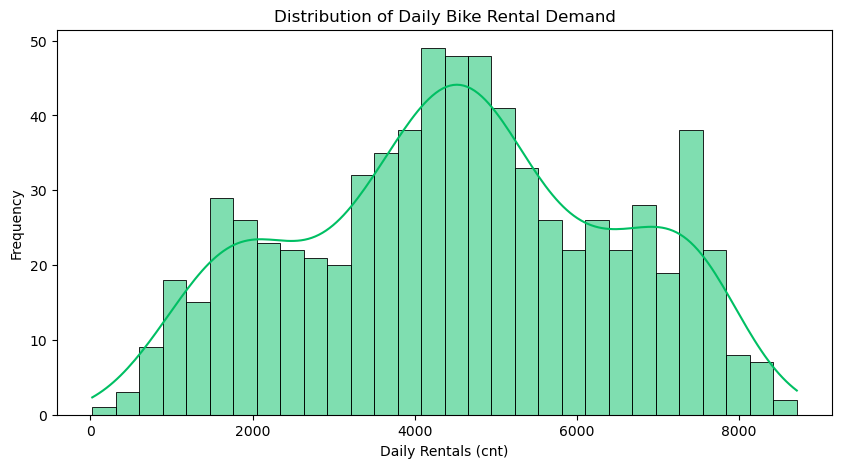

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
green_palette = [
    "#00bf63",  # darkest (main)
    "#33cc85",
    "#66d9a6",
    "#99e6c8"
]
colors = ["#00bf63", "#66d9a6", "#99e6c8", "#cccccc"]
plt.figure(figsize=(10, 5))
sns.histplot(day_clean["cnt"], bins=30, kde=True, color="#00bf63", edgecolor="black", linewidth=0.6)
plt.title("Distribution of Daily Bike Rental Demand")
plt.xlabel("Daily Rentals (cnt)")
plt.ylabel("Frequency")
plt.show()

**understanding**
1. Demand is not uniform -> demand varies substantially from day to day.
2. The distribution is roughly bell-shaped, but not perfectly normal -> different periods (e.g., seasons) may have different typical demand levels.
3. There are low-demand and high-demand days -> These extremes are important for: operational risk, capacity planning, defining “high” vs “low” demand later
4. No extreme spikes or gaps that suggest errors and looks plausible for real-world usage -> This confirms that the data is suitable for modeling.

#### Demand over time

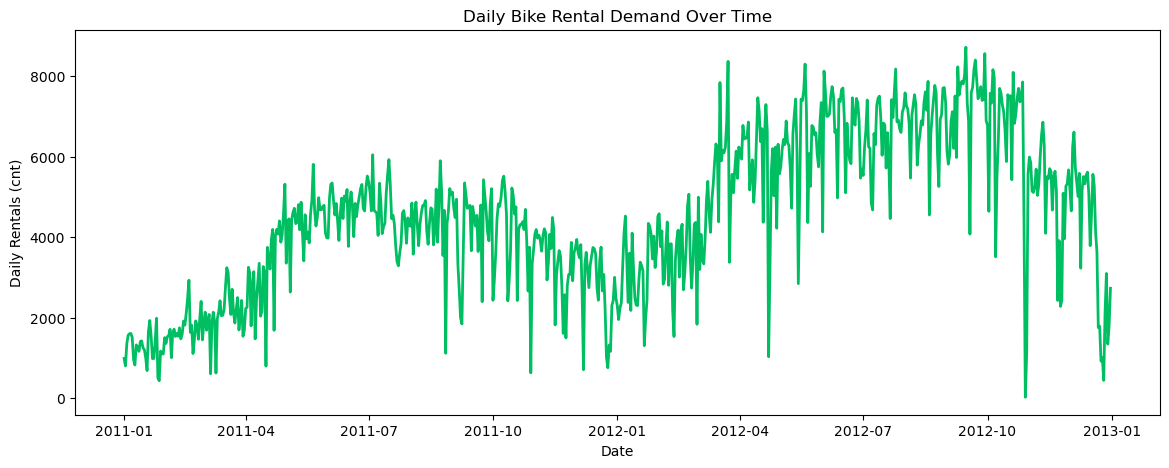

In [20]:
plt.figure(figsize=(14, 5))
plt.plot(day_clean["dteday"], day_clean["cnt"], color="#00bf63", linewidth=2)
plt.title("Daily Bike Rental Demand Over Time")
plt.xlabel("Date")
plt.ylabel("Daily Rentals (cnt)")
plt.show()

**understanding**
1. Strong seasonality -> Low demand in winter months/ Rising demand in spring/ High demand in summer/ Declining demand in late autumn -> season and month will be important predictors.
2. Overall growth from 2011 → 2012 -> Market growth (The yr variable will likely be important.)
3. High day-to-day fluctuations -> means weather effects, weekday/weekend differences, special conditions (e.g. storms, holidays)
4. Extreme low-demand days exist -> could be because of severe weather, holidays, data-specific events --> These days are important for risk management, not errors.

### Weather Sensitivity

#### Weather variables vs demand

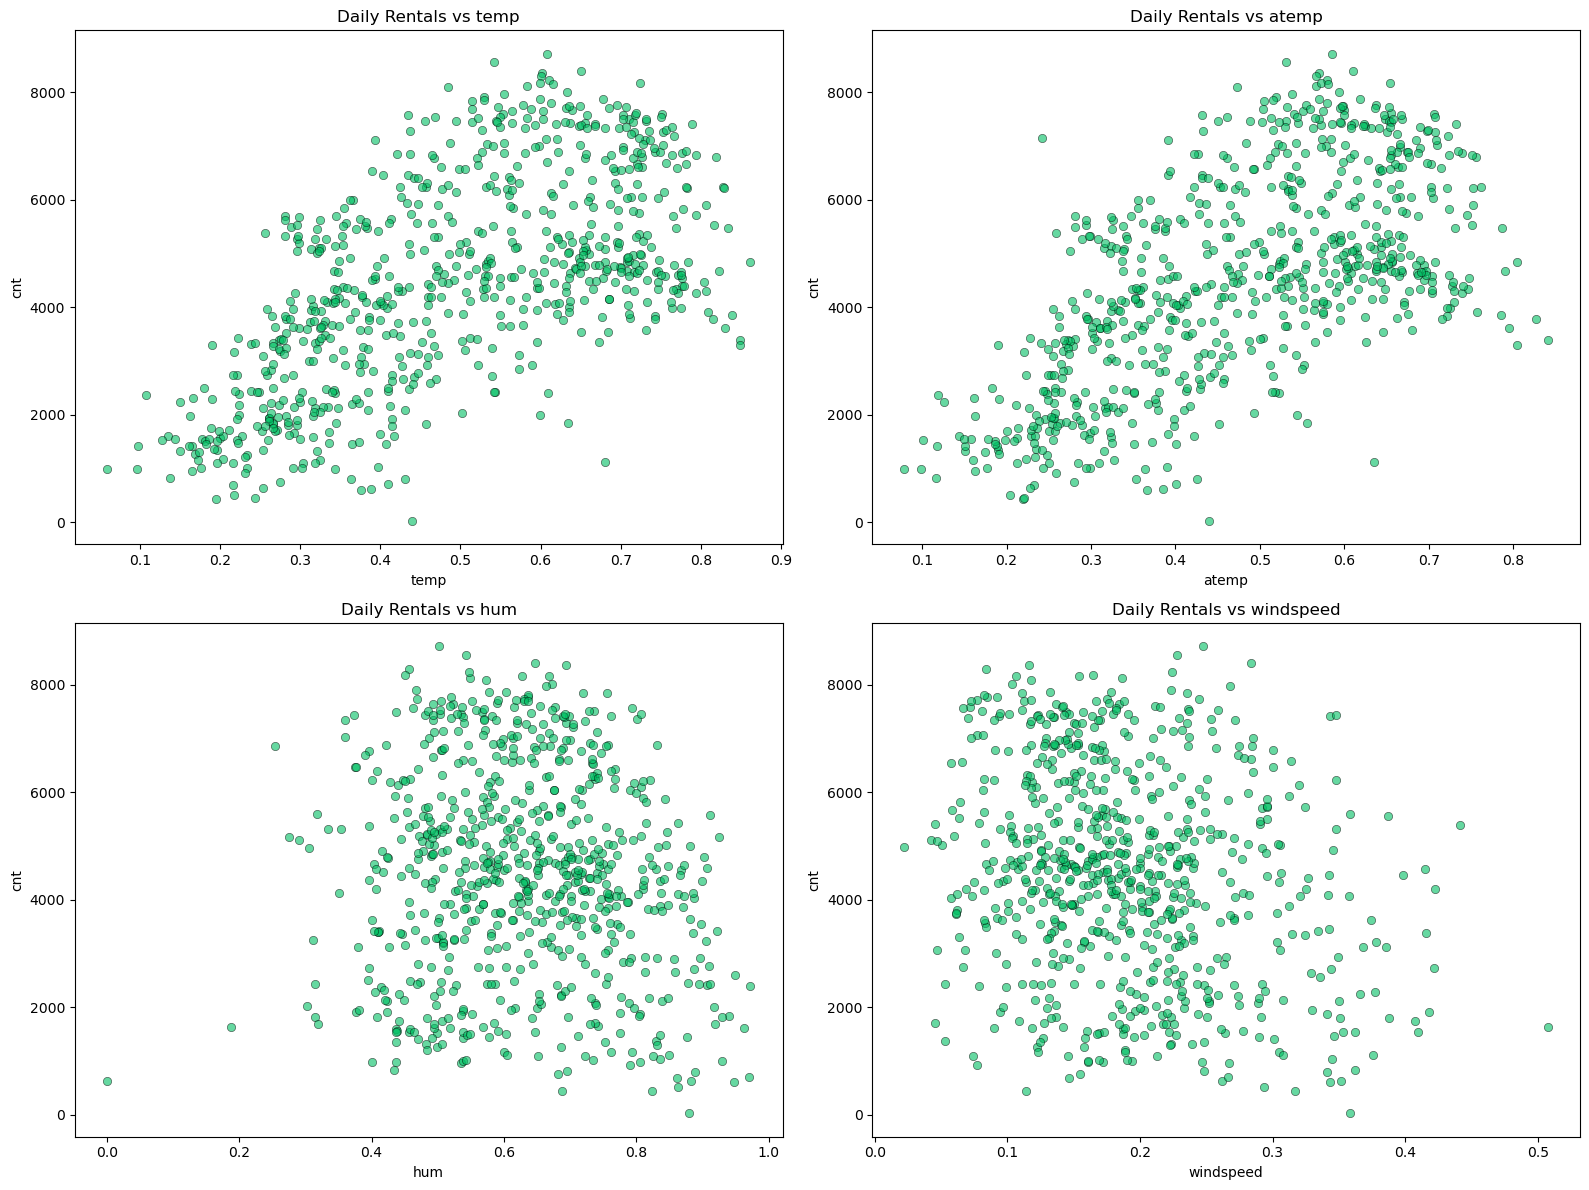

In [24]:
import math

weather_vars = ["temp", "atemp", "hum", "windspeed"]
target = "cnt"

cols = 2
rows = math.ceil(len(weather_vars) / cols)

fig, axes = plt.subplots(rows, cols, figsize=(16, 6 * rows))
axes = axes.flatten()

for i, col in enumerate(weather_vars):
    sns.scatterplot(data=day_clean, x=col, y=target, ax=axes[i], color="#00bf63", alpha=0.6, edgecolor="black")
    axes[i].set_title(f"Daily Rentals vs {col}")

plt.tight_layout()
plt.show()

**understanding**
Each dot = one day
1. Daily Rentals vs Temperature (temp) -> upward trend (Low demand at low temperatures/high demand at higher temperatures)/ one of the strongest relationships in the dataset
2. Daily Rentals vs Feeling Temperature (atemp) -> similar pattern to temp / Strong positive relationship ( temp and atemp likely carry overlapping information)
3. Daily Rentals vs Humidity -> No clear linear trend / Humidity alone does not strongly explain demand. Humidity may still be useful, but it is not a primary driver on its own.
4. Daily Rentals vs Wind Speed -> Very scattered points / No obvious trend / Wind speed appears to have limited direct influence on daily demand (maybe be droped? we will see)

#### Correlation matrix

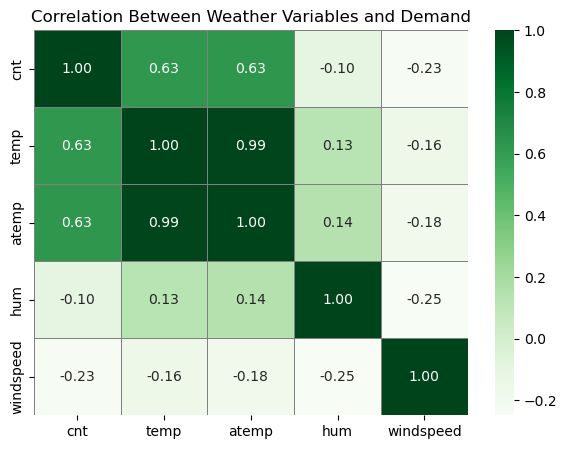

In [25]:
corr_vars = ["cnt", "temp", "atemp", "hum", "windspeed"]

plt.figure(figsize=(7, 5))
sns.heatmap(day_clean[corr_vars].corr(), annot=True, cmap="Greens", fmt=".2f", linewidths=0.5, linecolor="gray")
plt.title("Correlation Between Weather Variables and Demand")
plt.show()


**understanding**
1. Temperature & Demand correlation +0.63 --> Temperature is a key demand driver
2. Perceived temperature redundancy (temp vs atemp: +0.99) -> these two variables contain almost identical information / including both in a linear model would cause multicollinearity (may ned to drop one)
3. Humidity (cnt vs hum: −0.10) -> Weak negative relationship
4. Wind speed ( cnt vs windspeed: −0.23) -> Weak negative relationship

### Seasonal & Calendar Effects

#### Seasonality & weather condition (categorical)

Remember: Categorical variables require boxplots, not scatterplots.

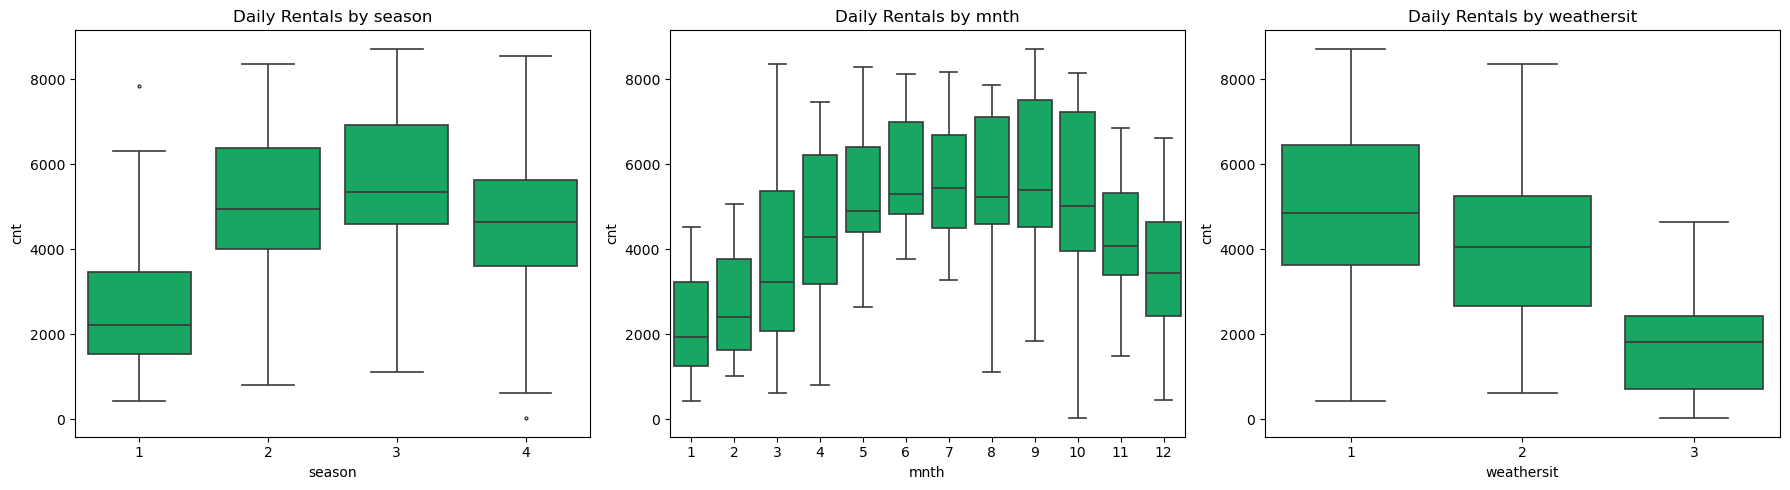

In [26]:
seasonal_vars = ["season", "mnth", "weathersit"]

cols = 3
fig, axes = plt.subplots(1, cols, figsize=(18, 5))

for i, col in enumerate(seasonal_vars):
    sns.boxplot(data=day_clean, x=col, y=target, ax=axes[i], color="#00bf63", fliersize=2, linewidth=1.2)
    axes[i].set_title(f"Daily Rentals by {col}")

plt.tight_layout()
plt.show()


**understanding**
1. Daily Rentals by Season -> Demand is strongly seasonal Warm seasons (spring & summer) clearly outperform winter
2. Daily Rentals by Month -> Peak demand around June–September -> This directly supports your market entry timing question
3. Daily Rentals by Weather Situation -> Daily Rentals by Weather Situation

**Findings for RQ1:** 
- Bike demand increases significantly with higher temperatures and during warmer seasons, while adverse weather conditions suppress usage.
- Weather and seasonality are critical predictors and must be central features in demand forecasting models.

# RQ2: Can periods of high and low demand be meaningfully distinguished to reduce business risk?

#### Define what “high demand” means (EDA-level)

In [11]:
day_clean["cnt"].describe()

count     731.000000
mean     4504.348837
std      1937.211452
min        22.000000
25%      3152.000000
50%      4548.000000
75%      5956.000000
max      8714.000000
Name: cnt, dtype: float64

#### demand percentiles

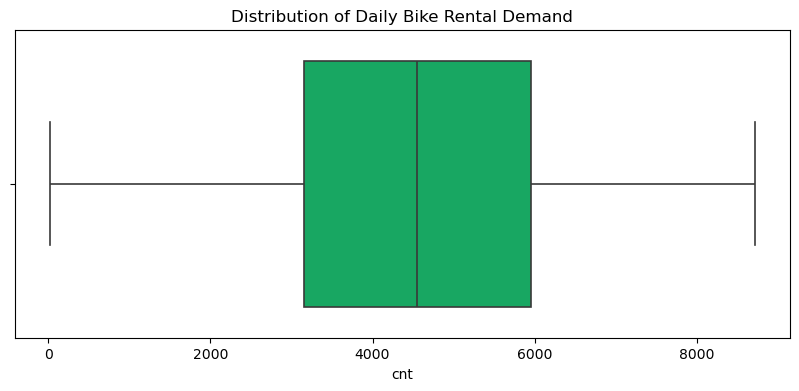

In [21]:
plt.figure(figsize=(10, 4))
sns.boxplot(x=day_clean["cnt"], color="#00bf63", linewidth=1.2, fliersize=3)
plt.title("Distribution of Daily Bike Rental Demand")
plt.show()

**understanding**
Can we identify high-demand periods to reduce risk? yes: Clear separation between low, medium, and high demand

#### Compare high vs low demand days

In [13]:
#Define a temporary high-demand label
threshold = day_clean["cnt"].quantile(0.75)

day_clean["high_demand_temp"] = (day_clean["cnt"] >= threshold).astype(int)

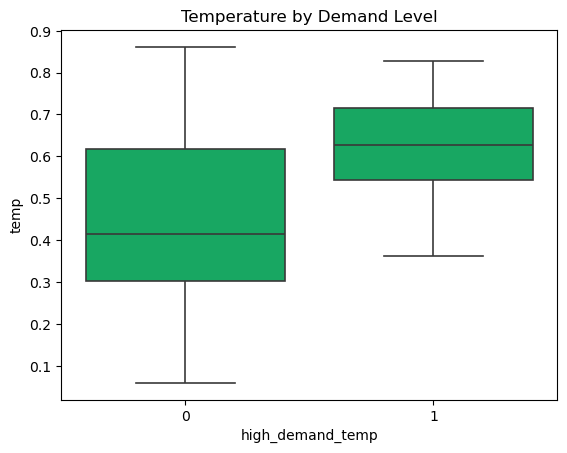

In [22]:
sns.boxplot(data=day_clean, x="high_demand_temp", y="temp",  color="#00bf63", linewidth=1.2, fliersize=3)
plt.title("Temperature by Demand Level")
plt.show()

**understanding**
1. High-demand days are warmer and The median temperature for high-demand days (1) is much higher than for low-demand days (0) -> High-demand days systematically occur at higher temperatures.
2. Separation between groups is strong -> Temperature provides meaningful separation between demand levels.
3. Low-demand days are more variable -> Low demand can occur under many conditions ( a wider temperature range/ more extreme cold values)

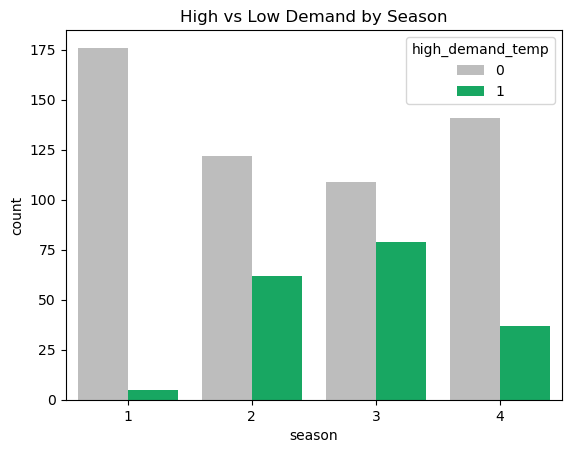

In [23]:
sns.countplot(data=day_clean, x="season", hue="high_demand_temp", palette={
        1: "#00bf63",   # High demand → brand green
        0: "#bdbdbd"    # Low demand → gray)
    }
)
plt.title("High vs Low Demand by Season")
plt.show()

**understanding**
Are high-demand days concentrated in certain seasons? 
1. High demand is very unlikely in winter (Season 1 has almost no high-demand days)
2. Summer dominates high-demand days (High demand is strongly seasonal, peaking in summer)

**Findings for RQ2:** 
- High-demand days occur predominantly during warmer conditions and specific seasons, showing clear separation from low-demand periods.
- Demand levels can be reliably classified, enabling proactive planning to reduce shortages and overcapacity risks.

# RQ3: When is the optimal time of year to launch a bike-sharing service to maximize early adoption?

#### Average demand by month

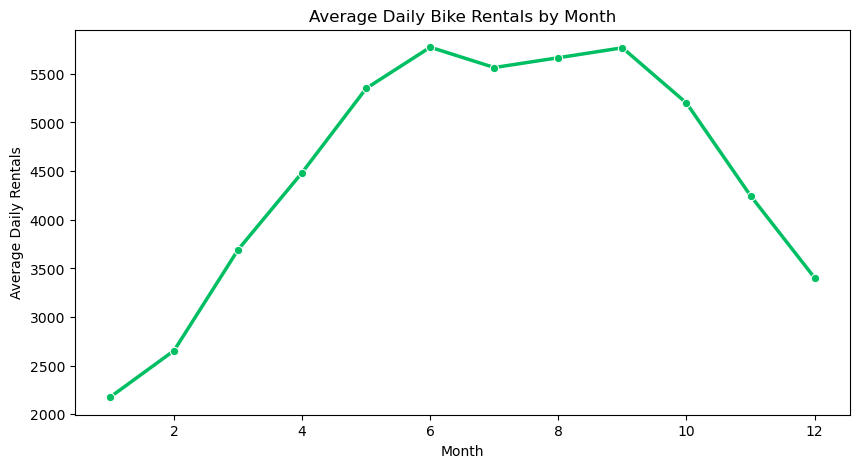

In [24]:
monthly_avg = (
    day_clean
    .groupby("mnth")["cnt"]
    .mean()
    .reset_index()
)

plt.figure(figsize=(10, 5))
sns.lineplot(data=monthly_avg, x="mnth", y="cnt", marker="o", color="#00bf63", linewidth=2.5)
plt.title("Average Daily Bike Rentals by Month")
plt.xlabel("Month")
plt.ylabel("Average Daily Rentals")
plt.show()

**understanding**
- answers when should we launch? and when are the peak months.

#### Average demand by season

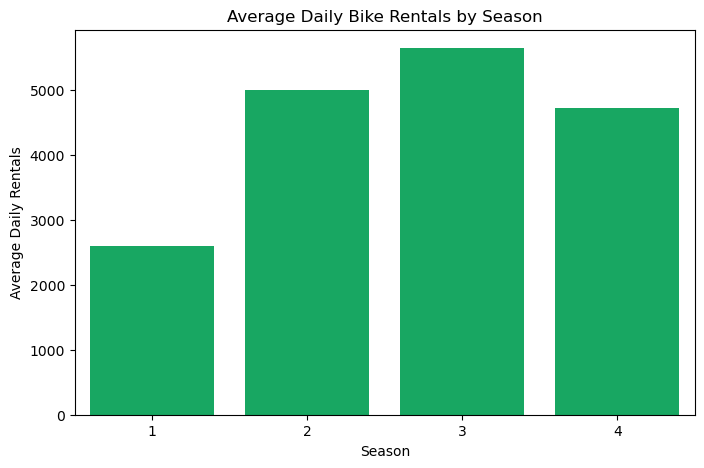

In [26]:
season_avg = (
    day_clean
    .groupby("season")["cnt"]
    .mean()
    .reset_index()
)

plt.figure(figsize=(8, 5))
sns.barplot(data=season_avg, x="season", y="cnt", color="#00bf63")
plt.title("Average Daily Bike Rentals by Season")
plt.xlabel("Season")
plt.ylabel("Average Daily Rentals")
plt.show()

**Findings for RQ3:** 
- Demand begins rising in spring, peaks in summer, and declines sharply in winter.
- Launching in spring or early summer maximizes early adoption while minimizing low-demand startup risk.

# RQ 4: How many bikes should be deployed on a typical day, and when should bikes be rebalanced (weekdays vs weekends)?

#### Weekday vs Weekend demand

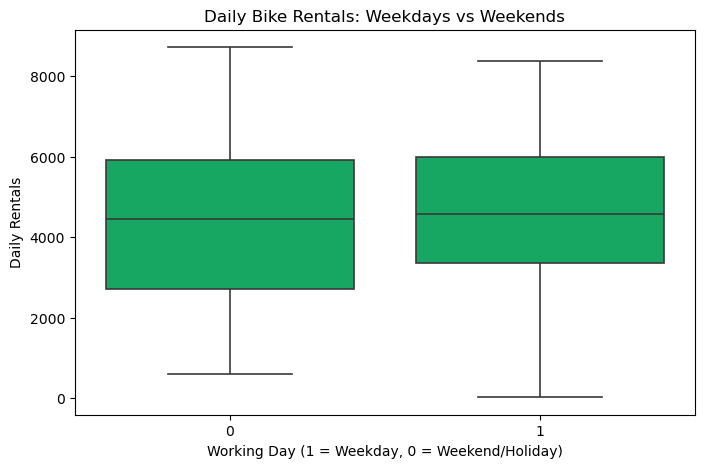

In [25]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=day_clean, x="workingday", y="cnt", color="#00bf63", linewidth=1.2, fliersize=3)
plt.title("Daily Bike Rentals: Weekdays vs Weekends")
plt.xlabel("Working Day (1 = Weekday, 0 = Weekend/Holiday)")
plt.ylabel("Daily Rentals")
plt.show()

**Understanding**
1. Weekdays have slightly higher median demand -> On average, weekdays generate more bike rentals (Likely due to commuting behavior.)
2. Weekends show greater variability -> Weekend demand is less predictable and more sensitive to external factors (weather, leisure behavior).
3. The two boxes overlap (so demand is not binary) -> weekdays are more stable/ weekends are riskier

Weekdays: Require a higher baseline number of bikes / Demand is more predictable → easier planning

Weekends: Require flexible rebalancing / Demand can spike or drop unexpectedly

**Findings for RQ4:** 
- Weekday demand is higher and more stable, while weekend demand is more variable.
- Higher baseline bike availability is needed on weekdays, with flexible rebalancing strategies on weekends.